In [25]:
%matplotlib inline
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from requests import get
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from IPython.core.display import SVG

In [26]:
DUNNHUMBY_PATH = '../data/dunnhumby - The Complete Journey CSV/'

In [27]:
nltk.download('stopwords')
from nltk.corpus import stopwords 
STOP_WORDS = list(set(stopwords.words('english')))
STOP_WORDS.append('NFS')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jerome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Definition of tools

Manual addition of words that we want to ignore to the Stopwords list

In [121]:
to_delete = ["added","ns","made","eaten","type","all","as","to","of"]
STOP_WORDS.append(to_delete)

In [107]:
def parse(str1): 
    """
    parses the string in a list of string (words) with all type of separators thanks to regexes
    """
    #matches any separator and any whitespace and transforms to mathc to lower case
    temp = list(filter(None,re.split("[\s;&@\/:,\*\.\(\)\{\}\\-%\"\'0-9]",str1)))
    #remove duplicate word, as there are many
    temp = list(dict.fromkeys(temp))
    temp = [i.lower() for i in temp if not i in STOP_WORDS]
    temp = [to_transform[i] if i in to_transform else i for i in temp]
    
    return temp

def trim_nutrient_name(str1):
    """
    simplifies the names of the nutrients for easier access afterwards
    """
    #matches any separator and any whitespace and transforms to match to lower case
    temp = temp.lower()
    temp = list(filter(None,re.split("[;&@\/:,\*\.\(\)\{\}\\%\"\']",str1)))
    #remove duplicate word, as there are many
    temp = [i for i in temp if not i in STOP_WORDS]
    if(temp[0] == "fatty acids"):
        return str.strip(temp[0] + temp[1])
    else:
        return str.strip(temp[0])

def get_amount(to_convert):
    """Returns the amount of a nutrient by taking into account the specified unit
    """
    if(to_convert.unit_name == "UG"):
        return to_convert.amount * 1e-6
    elif(to_convert.unit_name == "MG"):
        return to_convert.amount * 1e-3
    else:
        return to_convert.amount
    
def normalize_text(str1):
    """
    simplifies the names of the foods for easier access afterwards
    """
    #matches any separator and any whitespace and transforms to mathc to lower case
    temp = re.sub("[;&@\/:,\*\.\(\)\{\}\\%\"\']", ' ', str1)
    temp = temp.lower()
    words = temp.split()
    words = [i for i in words if not i in STOP_WORDS]
    temp = " ".join(sorted(set(words), key=words.index))
    return temp

# Import Data

In [93]:
products_df =  pd.read_csv(os.path.join(DUNNHUMBY_PATH,"product.csv"))

In [122]:
products_df.head(3)

,PRODUCT_ID,CURR_SIZE_OF_PRODUCT,ingredients
0,25671,22 LB,"[frozen, ice, crushed, cubed]"
2,26093,,"[bread, italian, french]"
3,26190,50 OZ,"[fruit, shelf, stable, apple, sauce]"


## Product Data

_We only take the categories which are food related, sorted manually the different departments_

In [95]:
products_sorted = products_df.groupby('DEPARTMENT').count().sort_values(by = 'PRODUCT_ID',ascending = False)
#NB: there are a few food in MISC. TRANS
food_related = np.array(['NUTRITION','GROCERY','PASTRY','MEAT-PCKGD','SEAFOOD-PCKGD','PRODUCE','DELI','MEAT','SALAD BAR','GRO BAKERY','FROZEN GROCERY','SPIRITS','RESTAURANT',''])

products_df = products_df[products_df.DEPARTMENT.isin(food_related)]

#we put all the description in a ingredients column
products_df['ingredients'] = products_df.COMMODITY_DESC + " " + products_df.SUB_COMMODITY_DESC
products_df.drop(["MANUFACTURER","DEPARTMENT","BRAND","COMMODITY_DESC","SUB_COMMODITY_DESC"],axis = 1, inplace = True)

In [96]:
#We see words in the product dataset, we would like to write them out completely for clarity
#TO ADD: SNKSCKYS/CRKR/CNDY
to_transform = dict({"frzn":"frozen","refrgratd":"refrigerated","brkfst":"breakfast","whlsm":"wholesome",\
                     "crkr":"cracker","cndy":"candy"})

In [97]:
products_df.ingredients = products_df.ingredients.apply(parse)

In [98]:
products_df.ingredients.head()

0           [frozen, ice, crushed, cubed]
2                [bread, italian, french]
3    [fruit, shelf, stable, apple, sauce]
4             [cookies, cones, specialty]
5          [spices, extracts, seasonings]
Name: ingredients, dtype: object

We see that we now have an easily parseable format

## Downloaded food nutrients data

In [99]:
dfList = {}
for r, d, f in os.walk('../data/health'):
    for file in f:
        if '.csv' in file:
            #print(file)
            dfList[file] = pd.read_csv(os.path.join(r, file))
            
branded_food_df = dfList['branded_food.csv']

#link the nutrient id with its name
nutrient_df = dfList['nutrient.csv']

#contains the food articles name and their id test commit
food_df = dfList['food.csv']

#contains the nutrients for each food article
food_nutrients_df = dfList['food_nutrient.csv']

# linke the food articles ids to their potential category
food_category_df = dfList['food_category.csv']

/Users/jerome/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/jerome/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


_We drop useless columns_

In [100]:
#drop unnecessary columns and rename to be more understandable
food_nutrients_df = food_nutrients_df.drop(["data_points","min","max","median","footnote","min_year_acquired","derivation_id"],axis=1)

nutrient_df = nutrient_df.drop(["nutrient_nbr","rank"],axis=1)

food_category_df.drop(["code"],axis=1,inplace=True)
food_category_df.rename(columns={'id':'food_category_id','description':'category'},inplace= True)

food_df.drop(["publication_date"],axis=1,inplace=True)

In [101]:
#filter out only the necessary food nutrients since we have 227, a lot of which aren't necessary to determine if a food is healthy
list_relevant_nutrients = ["Protein", "Total Carbohydrate","Total lipid (fat)","Sucrose",\
                            "Glucose (dextrose)","Sugars, total including NLEA","Fatty acids, total monounsaturated",\
                            "Fatty acids, total polyunsaturated","Fatty acids, total trans","Fatty acids, total saturated","Cholesterol",\
                            "Vitamin E, added","Vitamin K (phylloquinone)","Vitamin B-12","Vitamin B-6",\
                            "Vitamin E (label entry primarily)","Vitamin E (alpha-tocopherol)","Vitamin D","Vitamin A, RAE","Sodium, Na",\
                            "Total fat (NLEA)","Fiber, total dietary","Energy","Carbohydrate, by summation","Fructose"]

nutrient_df = nutrient_df[nutrient_df.name.isin(list_relevant_nutrients)]
nutrient_df.head(4)

,id,name,unit_name
1,1003,Protein,G
2,1004,Total lipid (fat),G
5,1008,Energy,KCAL
7,1010,Sucrose,G


In [102]:
nutrient_df.name = nutrient_df.name.apply(trim_nutrient_name)

UnboundLocalError: local variable 'temp' referenced before assignment

In [ ]:
nutrient_df.head(4)

In [ ]:
food_nutrients_df.head()

_Add the names of the nutrients to the nutrients per food_

In [ ]:
food_nutrients_df = food_nutrients_df.join(nutrient_df.set_index('id'),on='nutrient_id',how='inner')

#index the resulting table by multiindex: product id -> name of nutrients
food_nutrients_df = food_nutrients_df.set_index(pd.MultiIndex.from_frame(food_nutrients_df[['fdc_id','name']]))
#drop unnecessary columns 
food_nutrients_df = food_nutrients_df.drop(["id","fdc_id","nutrient_id","name"],axis=1)

In [ ]:
#here is the result
food_nutrients_df.loc[346049]

As an example, we show the food contents of corned beef, the format matches our needs

_We add the food category to food_df_

In [45]:
food_df = food_df.join(food_category_df.set_index("food_category_id"),on="food_category_id",how="left")
food_df.drop(["food_category_id"],axis=1,inplace=True)
food_df.head()

,fdc_id,data_type,description,category
0,346049,branded_food,"LIBBYS Corned Beef With Onion, 12 OZ",NaN
1,346050,branded_food,"LIBBYS Corned Beef With Chili, 12 OZ",NaN
2,346464,branded_food,WOLF Chili Without Beans,NaN
3,346466,branded_food,"WOLF Turkey Chili No Beans, 15 OZ",NaN
4,346468,branded_food,"WOLF BRAND Chili With Beans, 24 oz., 24 OZ",NaN


In [60]:
all_information_df = food_nutrients_df.join(food_df.set_index("fdc_id"))

We see that a lot of categories are unfortunately missing from the governement database

_At this stage we have 3 dataframes from our additional dataset for nutrition:_
- food_df = fdc_id vs name of food item (string)
- food_name_df = fdc_id vs parsed food title (list of string)
- food_nutrients_df = fdc_id vs nutrients contained (multiindex)
- all_information_df = fdc_id, nutrients, data type, description and food category

In [46]:
food_names_to_parse_df = food_df.copy()
food_names_to_parse_df.description = food_names_to_parse_df.description.apply(parse)

In [109]:
food_df.description = food_df.description.apply(normalize_text)

## Word Importance

_We filter the words according to their importance: that is, a word is more important as it apears many times in both datasets: (Ex: 'orange' is more important than 'artificial'). The words occuring in only one dataset are of no importance. The rest of the algorithm follows the following pipeline:_

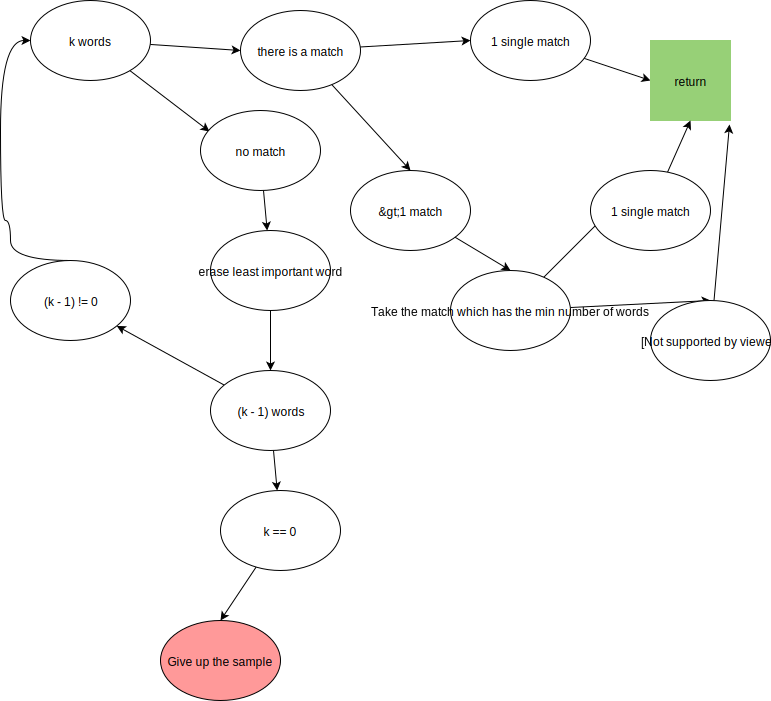

In [214]:
SVG(filename='untitled2.svg')

In [47]:
def get_allwords(serie):
    """
    serie: serie containing lists of words
    return a dataframe containing
      - column name: name of the unique articles found in the lists of the serie
      - column count: how many times they appear in the serie
    """
    allwords = np.concatenate(serie.ravel())
    allwords = pd.Series(allwords)
    allwords = pd.DataFrame(allwords,columns= ["name"])
    allwords.reset_index(inplace = True)
    allwords.rename(columns = {'index':'number'},inplace = True)
    allwords = allwords.groupby('name').count().sort_values(by = 'number',ascending = False)
    return allwords.reset_index()

#all words present in the nutrition dataset
all_words_nutrition = get_allwords(food_names_to_parse_df.description)

#all words present in the product dataset
all_words_supermarket = get_allwords(products_df.ingredients)

#### Inner merge between the 2 sets of words:

_we check which words occur in both dataframes: only these words will have importance in determining the type of food article we are dealing with. Of course, if no words are known from the nutrition dataset, the sample is not taken into account._


In [50]:
common_words = pd.merge(all_words_supermarket,all_words_nutrition,left_on = 'name',right_on = 'name',suffixes=('_supermarket', '_nutrition'))

In [187]:
print(common_words.size)
common_words.head()

3141


,name,number_supermarket,number_nutrition
0,frozen,5755,2633
1,snacks,3178,1913
2,meat,3090,2771
3,dry,2991,2533
4,premium,2423,4906


In [61]:
#Manual check to see which words occur in which dataset
print('chocolate' in all_words_nutrition.name.values)
print('chocolate' in all_words_supermarket.name.values)

True
True


## Assemble them together (and pray your god)

In [208]:
def get_matches(test,food_list):
    """
    test = list of strings to test
    food_list: pandas dataframe linking the food article/id to the lists of words of its name
    return all the articles whose words contain all of the words of test
    """
    res =[]
    for row in food_list.description:
        if all(el in test and len(test) == len(row.split()) for el in row.split()):
            res.append(row)
    return res
    
def get_importance(word):
    """
    word: string for which we want to know the importance
    return importance of word
    """
    if word in common_words.name.values:
        return common_words.loc[common_words["name"] == word]["number_supermarket"].values[0]
    else:
        return 0
    
def find_food(test,food_list):
    """
    implementation of the graphic above
    test = list of strings to test
    food_list: pandas dataframe linking the food article/id to the lists of words of its name
    return the best article
    """
    if len(test) == 0:
        #give up the sample
        return 0 #dummy
    
    matches = get_matches(test,food_list)
    if len(matches) == 0:
        importance = [get_importance(i) for i in test]
        mino = np.min(importance)
        test = [i for i in test if i != mino]
        return find_food(test,food_list)
    elif len(matches) == 1:
        return matches[0]
    else:
        sizes = [len(i) for i in matches]
        minsize = np.min(sizes)
        minsizes = [i for i in matches if len(i) == minsize]
        if len(minsizes) == 1:
            return minsizes[0]
        else:
            importances = [np.sum([get_importance(j) for j in trial]) for trial in minsizes]
            armin_imp = np.argmin(importances)
            return importances[armin_imp]
                

def find_food_naive(test,food_list):
    """
    food_list: pandas dataframe linking the food article/id id to the lists of words of its name
    test: list of strings you want to have an id for
    return the corresponding food indx
    """
    #TODO: improve the non unique max
    scores = [get_score(test,i) for i in food_list.description]
    maxo = np.max(scores)
    if len([1 for x in scores if x == maxo]) > 1:
        print("Multiple maximums!")
    armax = np.argmax(scores)
    print('result: ',food_list.description[armax])
    return food_list.fdc_id[armax]

def get_score(test,trial):
    """
    test: the list of strings you're trying to classify
    trial: the list you want the score for
    return the score of matching
    """
    return np.sum([1 for i in test if i in trial])

In [182]:
#TO DO
test1 = ['vanilla','creamy','swiss','miss','pudding','24','oz']
test2 = ['libbys']
get_matches(test1,food_df)
#food_df.description.head()

['swiss miss creamy vanilla pudding 24 oz']

In [210]:
get_importance("frozen")

5755

In [211]:
## test1 = ['vanilla','swiss','miss','pudding','24','oz']
print(find_food_naive(test1,food_df),find_food(test1,food_df))

Multiple maximums!
result:  swiss miss creamy vanilla pudding 24 oz


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jerome/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-211-28fe2c4c14c6>", line 2, in <module>
    print(find_food_naive(test1,food_df),find_food(test1,food_df))
  File "<ipython-input-208-f0ba039aaafb>", line 39, in find_food
    return find_food(test,food_list)
  File "<ipython-input-208-f0ba039aaafb>", line 39, in find_food
    return find_food(test,food_list)
  File "<ipython-input-208-f0ba039aaafb>", line 39, in find_food
    return find_food(test,food_list)
  [Previous line repeated 811 more times]
  File "<ipython-input-208-f0ba039aaafb>", line 34, in find_food
    matches = get_matches(test,food_list)
  File "<ipython-input-208-f0ba039aaafb>", line 9, in get_matches
    if all(el in test and len(test) == len(row.split()) for el in row.split()):
KeyboardInterrupt

During handling of the above exception, ano

KeyboardInterrupt: 

In [ ]:
#TO DO: put name and food category into gov database??